In [1]:
# Check python version
from platform import python_version
print(python_version())

3.10.8


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch as T
import torch.nn as nn
#from torchtext import data, datasets
#from torchtext.vocab import Vocab
import torch.optim as optim
import time
import copy
import torch
import torch.nn.functional as F
from torchsummary import summary
import math

# Common imports
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import dask
import math
import datetime
from collections import OrderedDict
from utils.datagenerator import *
from utils.util_data import * 
from utils.train import * 

In [4]:
print("Cuda Avaliable :", torch.cuda.is_available())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Cuda Avaliable : True
cuda


In [5]:
# open data from WeatherBench
DATADIR = '/storage/homefs/no21h426/WeatherBench-master/data/WeatherBench/5.625deg/'
# Load the entire dataset
z500 = xr.open_mfdataset(f'{DATADIR}geopotential_500/*.nc', combine='by_coords').z
t850 = xr.open_mfdataset(f'{DATADIR}temperature_850/*.nc', combine='by_coords').t.drop('level')
ds = xr.merge([z500, t850])

In [6]:
# only load a subset of the training data
ds_train = ds.sel(time=slice('2015', '2016'))  
ds_test = ds.sel(time=slice('2017', '2018'))

In [7]:

# then we need a dictionary for all the variables and levels we want to extract from the dataset
dic = OrderedDict({'z': None, 't': None})
lead_time =1
bs = 32
# Create a training and validation data generator. Use the train mean and std for validation as well.
dg_train = DataGenerator(
    ds_train.sel(time=slice('2015', '2015')), dic, lead_time, batch_size=bs, load=True)
dg_valid = DataGenerator(
    ds_train.sel(time=slice('2016', '2016')), dic, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, shuffle=False)


Loading data into RAM
Loading data into RAM


In [8]:
X,y=dg_train[0]
print(X.shape)

(32, 2, 32, 64)


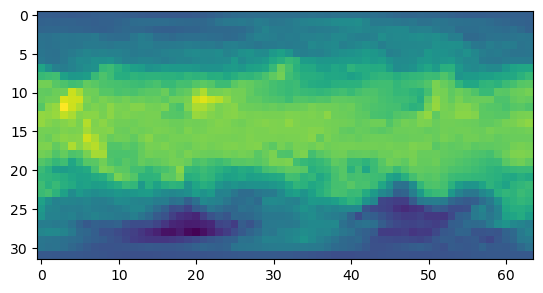

In [9]:
plt.imshow(X[0,1,:,:])

In [10]:
# First step: create patches and embeding
# I won't use this, but PatchEmbedding**
class PatchesCreate(torch.nn.Module):
    def __init__(self, batch_size = 32, img_size=(32, 64), patch_size=(4, 8), in_chans=2, embed_dim=64):
        super(PatchesCreate, self).__init__()
        self.patch_size = patch_size
        self.batch_size = batch_size
        self.img_size = img_size
        self.in_channel = in_chans
        self.num_patches =  (img_size[0] // patch_size[0]) * (img_size[1] // patch_size[1])
        
    def forward(self, images):
        print('need to convert to tensor')
        images = torch.as_tensor(images)
       
        grid_size1 = int(self.img_size[0]/self.patch_size[0])
        grid_size2 = int(self.img_size[1]/self.patch_size[1])
        
        Patches_Mask = torch.zeros(self.batch_size , self.in_channel*self.patch_size[0]*self.patch_size[1], grid_size1, grid_size2)
        
        for index, image in enumerate(images):
            for i in range(grid_size1):
                for j in range(grid_size2):
                    patch_image = image[:,i*self.patch_size[0]:(i+1)*self.patch_size[0], j*self.patch_size[1]:(j+1)*self.patch_size[1]]
                    Patches_Mask[index, :,  i, j ] = torch.flatten(patch_image)
                    Patches = torch.reshape(Patches_Mask, (self.batch_size, -1, self.in_channel*self.patch_size[0]*self.patch_size[1]))
                     
        #Patches = Patches.to(device)
        return Patches


In [11]:
class PatchEmbedding(nn.Module):
    """Split image into patches and then embed them.
    Parameters
    ----------
    img_size :  Size of the image (my case: it is not a square).
    patch_size : Size of the patch (my case: it is not a square).
    in_chans : int Number of input channels.
    embed_dim : int The emmbedding dimension. Embedding stays constant across entire network # patch_size * patch_size * in_chans
    Attributes
    ----------
    n_patches : int
        Number of patches inside of our image.
    proj : nn.Conv2d
        Convolutional layer that does both the splitting into patches
        and their embedding.
    """
    def __init__(self, img_size=(32, 64), patch_size=(4, 8), in_chans=2, embed_dim=64):
        super().__init__()
        def _make_tuple(x):
            if not isinstance(x, (list, tuple)):
                return (x, x)
            return x
        img_size, patch_size = _make_tuple(img_size), _make_tuple(patch_size)
       # print(patch_size)
        self.n_patches = (img_size[0] // patch_size[0]) * (
            img_size[1] // patch_size[1])
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
              

    def forward(self, X):
        # Output shape: (batch size, no. of patches, no. of channels)
        x = torch.as_tensor(X)
        x = self.proj(x) # (n_samples, embed_dim, n_patches ** 0.5, n_patches ** 0.5)
        x = x.flatten(2)  # (n_samples, embed_dim, n_patches)
        x = x.transpose(1, 2)  # (n_samples, n_patches, embed_dim)

        
        return x 

In [12]:
x = torch.randn(128, 2, 4)

In [13]:
#PatchEmbed = PatchEmbedding(img_size=(32, 64), patch_size=(4, 2),in_chans=2, embed_dim=64)
#patch_image = PatchEmbed(x)
#patch_image.shape

In [14]:
# Apatated: https://github.com/mjy8086/ViT_UNet/blob/main/ViT_UNet.py
# https://github.com/kv8-A/DL_reproducibility_TransUNet/blob/c9c62341f52a1d98778fbe6a14a568d7e281e947/model/transformers.py

In [12]:
class Attention(nn.Module):
    """Attention mechanism.
    Parameters
    ----------
    dim : int
        The input and out dimension of per token features.
    n_heads : int
        Number of attention heads.
    qkv_bias : bool
        If True then we include bias to the query, key and value projections.
    attn_p : float
        Dropout probability applied to the query, key and value tensors.
    proj_p : float
        Dropout probability applied to the output tensor.
    Attributes
    ----------
    scale : float
        Normalizing consant for the dot product.
    qkv : nn.Linear
        Linear projection for the query, key and value.
    proj : nn.Linear
        Linear mapping that takes in the concatenated output of all attention
        heads and maps it into a new space.
    attn_drop, proj_drop : nn.Dropout
        Dropout layers.
    """
    def __init__(self, dim=64, n_heads=8, qkv_bias=True, attn_p=0., proj_p=0.):
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = dim // n_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_p)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_p)

    def forward(self, x):
        """Run forward pass.
        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.
        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.
        """
        n_samples, n_tokens, dim = x.shape
    

        if dim != self.dim:
            raise ValueError

        qkv = self.qkv(x)  # (n_samples, n_patches + 1, 3 * dim)
        qkv = qkv.reshape(
                n_samples, n_tokens, 3, self.n_heads, self.head_dim
        ) 
        # (n_smaples, n_patches + 1, 3, n_heads, head_dim)
        qkv = qkv.permute(
                2, 0, 3, 1, 4
        )  # (3, n_samples, n_heads, n_patches + 1, head_dim)
       
        q, k , v = qkv[0], qkv[1], qkv[2]
        
        k_t = k.transpose(-2, -1)  # (n_samples, n_heads, head_dim, n_patches + 1)
      
        dp = (
           q @ k_t
        ) * self.scale # (n_samples, n_heads, n_patches + 1, n_patches + 1)
        attn = dp.softmax(dim=-1)  # (n_samples, n_heads, n_patches + 1, n_patches + 1)
        attn = self.attn_drop(attn)

        weighted_avg = attn @ v  # (n_samples, n_heads, n_patches +1, head_dim)
        weighted_avg = weighted_avg.transpose(
                1, 2
        )  # (n_samples, n_patches + 1, n_heads, head_dim)
        weighted_avg = weighted_avg.flatten(2)  # (n_samples, n_patches + 1, dim)

        x = self.proj(weighted_avg)  # (n_samples, n_patches + 1, dim)
        x = self.proj_drop(x)  # (n_samples, n_patches + 1, dim)

        return x

In [13]:
# One hidden layer, Gaussion linear unnit activation functiuon GELU will be used
class MLP(nn.Module):
    """Multilayer perceptron.
    Parameters
    ----------
    in_features : int
        Number of input features.
    hidden_features : int
        Number of nodes in the hidden layer.
    out_features : int
        Number of output features.
    p : float
        Dropout probability.
    Attributes
    ----------
    fc : nn.Linear
        The First linear layer.
    act : nn.GELU
        GELU activation function.
    fc2 : nn.Linear
        The second linear layer.
    drop : nn.Dropout
        Dropout layer.
    """
    def __init__(self, in_features, hidden_features, out_features, p=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(p)

    def forward(self, x):
        """Run forward pass.
        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_patches + 1, in_features)`.
        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches +1, out_features)`
        """
        x = self.fc1(
                x
        ) # (n_samples, n_patches + 1, hidden_features)
        x = self.act(x)  # (n_samples, n_patches + 1, hidden_features)
        x = self.drop(x)  # (n_samples, n_patches + 1, hidden_features)
        x = self.fc2(x)  # (n_samples, n_patches + 1, hidden_features)
        x = self.drop(x)  # (n_samples, n_patches + 1, hidden_features)

        return x

In [14]:
class Block(nn.Module):
    """Transformer block.
    Parameters
    ----------
    dim : int
        Embeddinig dimension.
    n_heads : int
        Number of attention heads.
    mlp_ratio : float
        Determines the hidden dimension size of the `MLP` module with respect
        to `dim`.
    qkv_bias : bool
        If True then we include bias to the query, key and value projections.
    p, attn_p : float
        Dropout probability.
    Attributes
    ----------
    norm1, norm2 : LayerNorm
        Layer normalization.
    attn : Attention
        Attention module.
    mlp : MLP
        MLP module.
    """
    def __init__(self, dim = 64, n_heads = 8, mlp_ratio=4.0, qkv_bias=True, p=0., attn_p=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)    #This is the first layer norm
        # This is the MSA 
        self.attn = Attention(
                dim,
                n_heads=n_heads,
                qkv_bias=qkv_bias,
                attn_p=attn_p,
                proj_p=p
        )
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)   # second layer norm
        hidden_features = int(dim * mlp_ratio)
        # This is where the MLP layer comes in 
        self.mlp = MLP(
                in_features=dim,
                hidden_features=hidden_features,
                out_features=dim,
        )

    def forward(self, x):
        """Run forward pass.
        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.
        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.
        """
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))

        return x


In [15]:
class ViTencoder(nn.Module):
    def __init__(self, embed_dim, depth = 12):
        super().__init__()
        self.embed_dim = embed_dim
        self.depth = depth
        self.layer = nn.ModuleList()
        self.encoder_norm = nn.LayerNorm(self.embed_dim, eps=1e-6)
        for _ in range(self.depth):
            layer = Block()
            self.layer.append(copy.deepcopy(layer))

    def forward(self, hidden_states):


        for layer_block in self.layer:
            hidden_states = layer_block(hidden_states)

        encoded = self.encoder_norm(hidden_states)
        return encoded

In [16]:
class Conv2dReLU(nn.Sequential):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            padding=0,
            stride=2,
            use_batchnorm=True,
    ):
        conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride=stride,
            padding=padding,
            bias=not (use_batchnorm),
        )
        relu = nn.ReLU(inplace=True)

        bn = nn.BatchNorm2d(out_channels)

        super(Conv2dReLU, self).__init__(conv, bn, relu)

In [17]:
# now merge everything 
class ViT(nn.Module):
    def __init__(
            self,
            img_size,
            embed_dim,       #64,
            patch_size=(1,2),
            in_chans = 128, #(4,8),
            depth=12,           #This is 12 for TransUNet
           # n_heads=12,
    ):
        super(ViT, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.in_chans = in_chans
        self.depth = depth
        self.patch_embed = PatchEmbedding(
                img_size=self.img_size,
                patch_size=self.patch_size,
                in_chans=self.in_chans,
                embed_dim=self.embed_dim,
        )
       
        #print(self.patch_embed)
        self.encoder = ViTencoder(self.embed_dim)
        
        self.down_factor = 4
        self.conv_more = Conv2dReLU(self.embed_dim, 128, kernel_size=1, use_batchnorm=True)

    def forward(self, input_ids):
        # embedding_output, features = self.embeddings(input_ids)
        # encoded, attn_weights = self.encoder(embedding_output)  # (B, n_patch, hidden)
        # return encoded, attn_weights, features

        embedding_output = self.patch_embed(input_ids)
        encoded = self.encoder(embedding_output)  # (B, n_patch, hidden)
       # print(encoded.shape)
        B, n_patch, hidden = encoded.size()
        l, h = (self.img_size[0] // 2**self.down_factor // self.patch_size[0]), (self.img_size[1] // 2**self.down_factor // self.patch_size[1])
    
        x = encoded.permute(0, 2, 1)
       # print(x.shape)
        x = x.contiguous().view(B, hidden, l, h)

        x = self.conv_more(x)
        return x

In [21]:
# Just for checking
p = PatchEmbedding((32,64), (2,4), 128, 128)
img_size = (32,64)
patch_size = (2,4)
#encoder = ViTencoder(embed_dim=128)
#conv_more = Conv2dReLU(128, 128, kernel_size=1, use_batchnorm=True)

In [22]:
#pt = p(test)
#encoder(pt).shape

In [23]:
#encoder = ViT(img_size=(32,64), patch_size=(2,4), in_chans=128, embed_dim=128)
#y= encoder(test)


In [27]:
#class BlockU(nn.Module):
#    def __init__(self, in_ch, out_ch,  kernel_size, padding):
#        super().__init__()
#        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, stride=1, padding=padding)
#        self.relu  = nn.ReLU()
#        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=kernel_size, stride=1, padding=padding)
#    
#    def forward(self, x):
#        return self.relu(self.conv2(self.relu(self.conv1(x))))

In [28]:
#class Encoder(nn.Module):
#    def __init__(self, chs=(2,64,128,256,512,1024)):
#        super().__init__()
#        self.enc_blocks = nn.ModuleList([BlockU(chs[i], chs[i+1], 3, 1) for i in range(len(chs)-1)])
#        self.pool       = nn.MaxPool2d(2)
    
#    def forward(self, x):
#        ftrs = []
#        for block in self.enc_blocks:
#            x = block(x)
#            ftrs.append(x)
#            x = self.pool(x)
#        return ftrs

In [29]:
#encoder = Encoder()
# input image
#Xt = torch.as_tensor(X)
#x    = torch.randn(32, 2,32, 64)
#ftrs = encoder(Xt)
#for ftr in ftrs: print(ftr.shape)

In [18]:
def match_size(x, size):
    _, h1, w1, d1 = x.shape
    h2, w2, d2 = size
    #print(size)

    while d1 != d2:
        if d1 < d2:
            x = nn.functional.pad(x, (0, 1), mode='constant', value=0)
            d1 += 1
        else:
            x = x[ :, :, :, :d2]
            break
    while w1 != w2:
        if w1 < w2:
            x = nn.functional.pad(x, (0, 0, 0, 1), mode='constant', value=0)
            w1 += 1
        else:
            x = x[ :, :, :w2, :]
            break
    while h1 != h2:
        if h1 < h2:
            x = nn.functional.pad(x, (0, 0, 0, 0, 1), mode='constant', value=0)
            h1 += 1
        else:
            x = x[ :, :h2, :, :]
            break
    return x

In [19]:

class CNNencoder(nn.Module):
    def __init__(self, channel_in, channel_out):
        super().__init__()
        self.channel_in = channel_in
        self.channel_out = channel_out
        self.model = nn.Sequential(
            nn.Conv2d(self.channel_in , self.channel_out, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(inplace=True))

    def forward(self, x):
        out = self.model(x)
        return out

class CNNdecoder(nn.Module):
    def __init__(self, channel_in, channel_out):
        super().__init__()
        self.channel_in = channel_in
        self.channel_out = channel_out
        self.model = nn.Sequential(
            nn.ConvTranspose2d(self.channel_in , self.channel_out, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(inplace=True)
        )

    def forward(self, x, skip_x):
        x = self.model(x)
        if x.size() != skip_x.size():
            x = match_size(x, skip_x.shape[1:])

        x = torch.cat((x, skip_x), 1)
        return x

In [20]:
def padding_block( x, factor):
        h, w = x.size()[2:4]
        dh = 0
        dw = 0
        if h % factor > 0:
            dh = factor - h % factor
        if w % factor > 0:
            dw = factor - w % factor
        if dh > 0 or dw > 0:
            top_pad = dh//2
            bottom_pad = dh//2 + dh%2
            left_pad = dw//2
            right_pad = dw//2 + dw%2
            x = nn.ZeroPad2d(padding=((top_pad, bottom_pad), (left_pad, right_pad)))(x)
        
        return x

In [21]:
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels, img_size, patch_size, embed_dim):
        super().__init__()

        nf = 16
        self.in_chans = in_channels 
        self.out_channels = out_channels
        self.img_size = img_size
        self.patch_size = patch_size
        self.embed_dim = embed_dim

        self.pooling = nn.MaxPool2d(kernel_size=2)

        self.conv1 = CNNencoder(self.in_chans, nf)
        self.conv2 = CNNencoder(nf, nf*2)
        self.conv3 = CNNencoder(nf*2, nf*4)
        self.conv4 = CNNencoder(nf*4, nf*8)
        self.conv5 = CNNencoder(nf*8, nf*8)
        # get the right shapes
        
        self.vit = ViT(img_size=self.img_size, embed_dim = self.embed_dim, patch_size = self.patch_size)

        self.up1 = CNNdecoder(nf*8, nf*8)
        self.up2 = CNNdecoder(nf*8*2, nf*4)
        self.up3 = CNNdecoder(nf*4*2, nf*2)
        self.up4 = CNNdecoder(nf*2*2, nf)

        self.out = nn.Sequential(
            nn.Conv2d(nf*2, out_channels, kernel_size=1, stride=1, bias=False),
            nn.LeakyReLU(inplace=True)
        )
  

    def forward(self, x):
            c1 = self.conv1(x)
            p1 = self.pooling(c1)

            c2 = self.conv2(p1)
            p2 = self.pooling(c2)

            c3 = self.conv3(p2)
            p3 = self.pooling(c3)

            c4 = self.conv4(p3)
            p4 = self.pooling(c4)

            c5 = self.conv5(p4)
            #print(c5.shape)
            v1 = self.vit(c5)
            
            u1 = self.up1(v1, c4)
            u2 = self.up2(u1, c3)
            u3 = self.up3(u2, c2)
            u4 = self.up4(u3, c1)
            out = self.out(u4)
            if x.size() != out.size():
                out = match_size(out, x.shape[1:])



            return out

In [22]:
model1 = Generator(in_channels=2, out_channels=2,img_size=(32,64), patch_size = (1,2), embed_dim = 64).to(device)
#print(list(model1.parameters()))


In [23]:
summary(model1, (2,32,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 64]             304
         LeakyReLU-2           [-1, 16, 32, 64]               0
        CNNencoder-3           [-1, 16, 32, 64]               0
         MaxPool2d-4           [-1, 16, 16, 32]               0
            Conv2d-5           [-1, 32, 16, 32]           4,640
         LeakyReLU-6           [-1, 32, 16, 32]               0
        CNNencoder-7           [-1, 32, 16, 32]               0
         MaxPool2d-8            [-1, 32, 8, 16]               0
            Conv2d-9            [-1, 64, 8, 16]          18,496
        LeakyReLU-10            [-1, 64, 8, 16]               0
       CNNencoder-11            [-1, 64, 8, 16]               0
        MaxPool2d-12             [-1, 64, 4, 8]               0
           Conv2d-13            [-1, 128, 4, 8]          73,856
        LeakyReLU-14            [-1, 12

In [24]:
Xt = torch.as_tensor(X)
print(Xt.shape)

torch.Size([32, 2, 32, 64])


In [25]:
# Checks
Xt = Xt.to(device)
test= model1(Xt)

In [26]:
test.shape

torch.Size([32, 2, 32, 64])

In [27]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 10

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(params = model1.parameters(), lr = learning_rate, weight_decay = weight_decay)
#optimizer = torch.optim.SGD(params = model1.parameters(), lr = learning_rate, weight_decay = weight_decay)

In [28]:
# training for 10 epochs
train_loss=[]
test_loss=[]
for epoch in range(num_epochs):    
    # run validation loop on training to compute training loss
    train_loss_epoch = train_one_epoch(model1, dg_train, optimizer, loss_fn)
    # run validation loop on testing to compute test loss
    test_loss_epoch = validate_one_epoch(model1, dg_valid, optimizer,loss_fn)
    
    print(f"Epoch {epoch},Train MSE: {train_loss_epoch:.4f} Test MSE: {test_loss_epoch:.3f}")
    
    train_loss.append(train_loss_epoch)
    test_loss.append(test_loss_epoch)

cuda
cuda
Epoch 0,Train MSE: 4.7159 Test MSE: 3.753
cuda
cuda
Epoch 1,Train MSE: 3.5878 Test MSE: 2.879
cuda
cuda
Epoch 2,Train MSE: 3.0920 Test MSE: 2.598
cuda
cuda
Epoch 3,Train MSE: 2.4099 Test MSE: 1.651
cuda
cuda
Epoch 4,Train MSE: 1.2417 Test MSE: 0.715
cuda
cuda
Epoch 5,Train MSE: 0.5114 Test MSE: 0.365
cuda
cuda
Epoch 6,Train MSE: 0.3235 Test MSE: 0.320
cuda
cuda
Epoch 7,Train MSE: 0.2933 Test MSE: 0.293
cuda
cuda
Epoch 8,Train MSE: 0.2720 Test MSE: 0.304
cuda
cuda
Epoch 9,Train MSE: 0.2650 Test MSE: 0.321


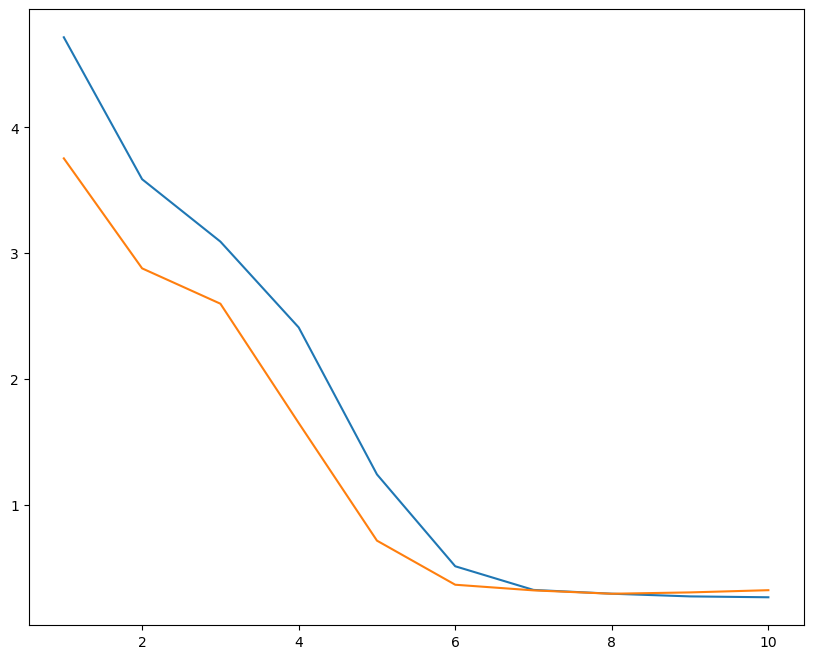

In [29]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(test_loss)+1),test_loss,label='Validation Loss')

In [30]:
train_loss = 0.0
val_loss = 0.0

trainingEpoch_loss = []
validationEpoch_loss = []

size = len(dg_train.data)

  # Run the training loop
for epoch in range(0, 5): # 5 epochs at maximum
    
    # Print epoch
    print(f'Starting epoch {epoch+1}')
    
    # Set current loss value
    current_loss = []
    
    # Iterate over the DataLoader for training data
    for batch, (X,y) in enumerate(dg_train):
        
        Xt = torch.as_tensor(X).to(device)
        yt = torch.as_tensor(y).to(device)

        # Zero the gradients
        optimizer.zero_grad()
        
        pred = model1(Xt).to(device)
        # compute loss 
        loss = loss_fn(pred, yt).to(device)

        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()
      
        # Print statistics
        current_loss.append(loss.item())
        
    trainingEpoch_loss.append(np.array(current_loss).mean())
        

    # Validation
    with torch.no_grad():
        for batch, (X,y) in enumerate(dg_valid):
            
                validationStep_loss = []
                
                Xt = torch.as_tensor(X).to(device)
                yt = torch.as_tensor(y).to(device)

                # Zero the gradients
                optimizer.zero_grad()
                    
                pred_val = model1(Xt)
                # compute loss 
                validation_loss = loss_fn(pred_val, yt).to(device)

                validationStep_loss.append(validation_loss.item())
            
        validationEpoch_loss.append(np.array(validationStep_loss).mean())


Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5


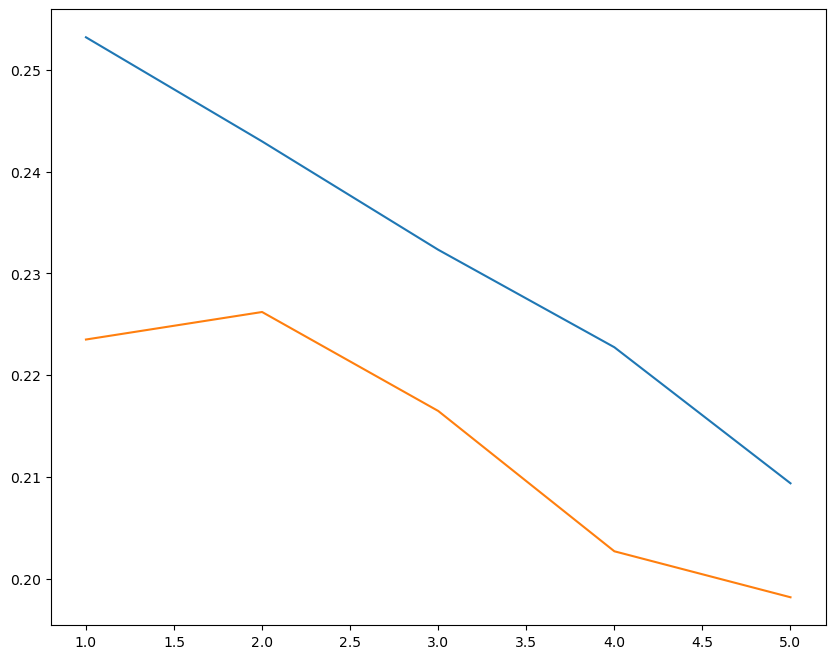

In [31]:
# Plot results
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(trainingEpoch_loss)+1),trainingEpoch_loss, label='Training Loss')
plt.plot(range(1,len(validationEpoch_loss)+1),validationEpoch_loss,label='Validation Loss')

In [44]:
# Look at the predictions
#from utils_predictions import *

In [45]:
preds = []
for batch, (X,y) in enumerate(dg_valid):
    Xt = torch.as_tensor(X).to(device)
    yt = torch.as_tensor(y).to(device)
    pred_val = model1(Xt)
    preds.append(pred_val.cpu().detach().numpy())

In [46]:
all_preds = np.concatenate(preds)

In [47]:
all_preds.shape

(8783, 2, 32, 64)

In [48]:
dg_valid.data.shape

(8784, 2, 32, 64)

In [49]:
#Let's visualize it

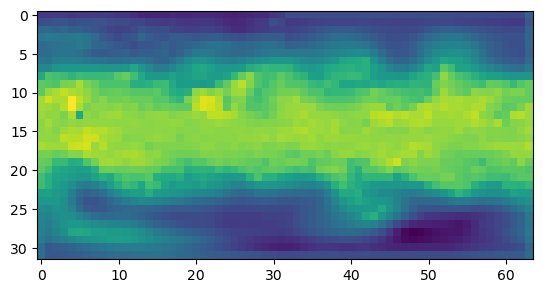

In [50]:
plt.imshow(all_preds[1,1,:,:])

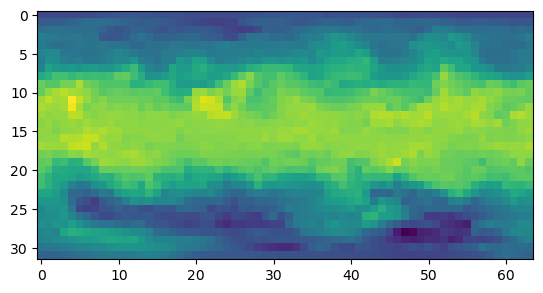

In [51]:
plt.imshow(dg_valid.data[0,1,:])

In [ ]:
## train only VIT